In [1]:
import warnings
import torch
from molecule import MoleculeTrainer
from gflownet.config import init_empty, Config
from rdkit.Chem.Draw import MolsToGridImage
import pathlib

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


Run the model with comparing openpom probability vectors as reward

In [2]:
import pandas as pd
import random
import datetime

In [3]:
# Get vanilla molecules

df = pd.read_csv("data.csv")
df.head()

,nonStereoSMILES,descriptors,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
0,CC(O)CN,fishy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CCC(=O)C(=O)O,fatty;lactonic;sweet;caramellic;creamy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,O=C(O)CCc1ccccc1,rose;floral;fatty;sweet;musk;cinnamon;balsamic,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OCc1ccc(O)cc1,medicinal;phenolic;fruity;nutty;bitter;sweet;a...,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,O=Cc1ccc(O)cc1,phenolic;woody;nutty;vanilla;hay;metallic;swee...,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [4]:
vanilla_mols_df = df.loc[df['vanilla'] == 1]
vanilla_mols_df.head()
#vanilla = index 64


,nonStereoSMILES,descriptors,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
4,O=Cc1ccc(O)cc1,phenolic;woody;nutty;vanilla;hay;metallic;swee...,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
26,COc1ccccc1O,medicinal;savory;phenolic;woody;smoky;vanilla;...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
32,O=C1CCc2ccccc2O1,herbal;nutty;vanilla;coumarinic;hay;tobacco;sw...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
64,COc1cc(C=O)ccc1O,chocolate;vanilla;creamy;sweet,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
67,COc1cc(C(C)=O)ccc1O,vanilla;sweet,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [5]:
# 70% training data 

round(len(vanilla_mols_df)*0.7)
vanilla_smiles_trainig= list(vanilla_mols_df["nonStereoSMILES"])
vanilla_smiles_trainig = random.sample(vanilla_smiles_trainig, round(len(vanilla_mols_df)*0.7))
random.shuffle(vanilla_smiles_trainig)
vanilla_smiles_test = []
for i in vanilla_mols_df["nonStereoSMILES"]:
    if i not in vanilla_smiles_trainig:
        vanilla_smiles_test.append(i)

len(vanilla_smiles_trainig),round(len(vanilla_mols_df)*0.7),len(vanilla_mols_df["nonStereoSMILES"]),len(vanilla_smiles_test)


(78, 78, 111, 33)

In [ ]:
datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

'2024-11-16_17:04:52'

In [7]:
from rdkit.Chem.AtomPairs.Utils import CosineSimilarity
from rdkit import Chem



In [8]:
Chem.RDKFingerprint(Chem.MolFromSmiles("COc1cc(C=O)ccc1O"))


In [9]:
from pom_models.functions import fragance_propabilities_from_smiles

In [10]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Run on cpu
dev = torch.device('cpu')

# Vanillin
vanillin_smiles = ["COc1cc(C=O)ccc1O"] #vanilla_smiles_trainig #["[H]C(=O)C1=CC(OC)=C(O)C=C1"]



# Initialize model
config = init_empty(Config())
config.print_every = 1
config.log_dir = f"openpom_fixed_invalids_{datetime.datetime.now().strftime('%Y-%m-%d__%H_%M_%S')}"
config.device = dev
config.num_training_steps = 150
config.num_workers = 0
config.num_validation_gen_steps = 1
config.overwrite_existing_exp=False
config.checkpoint_every = 100
config.algo.max_nodes = 12 # 95 quantil
config.store_all_checkpoints = True

trial = MoleculeTrainer(config,vanillin_smiles, print_config=True)
trial.run()



"""# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])

  
state = {
    "models_state_dict": [trial.model.state_dict()],
    "cfg": trial.cfg,
    "env_ctx": trial.model.env_ctx,
    #"model": trial.model,
}
if trial.sampling_model is not trial.model:
    state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
with open(fn, "wb") as fd:
    torch.save(
        state,
        fd,
    )"""



Hyperparameters:

desc: noDesc
log_dir: openpom_fixed_invalids_2024-11-16__17_04_52
device: cpu
seed: 0
validate_every: 1000
checkpoint_every: 100
store_all_checkpoints: true
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 150
num_workers: 0
hostname: null
pickle_mp_messages: false
git_hash: f106cde
overwrite_existing_exp: false
algo:
  method: TB
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 12
  max_edges: 128
  illegal_action_logreward: -1.0
  train_random_action_prob: 0.0
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
  

'# Generate molecules\ntrajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)\nobjs = [trial.ctx.graph_to_obj(i[\'result\']) for i in trajs]\nobj_props, _ = trial.task.compute_obj_properties(objs)\nlog_rewards = trial.task.cond_info_to_logreward({\'beta\': torch.ones(len(trajs))}, obj_props)\nMolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f\'reward: {r.exp().item():.2f}\' for r in log_rewards[:25]])\n\n  \nstate = {\n    "models_state_dict": [trial.model.state_dict()],\n    "cfg": trial.cfg,\n    "env_ctx": trial.model.env_ctx,\n    #"model": trial.model,\n}\nif trial.sampling_model is not trial.model:\n    state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]\nfn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"\nwith open(fn, "wb") as fd:\n    torch.save(\n        state,\n        fd,\n    )'

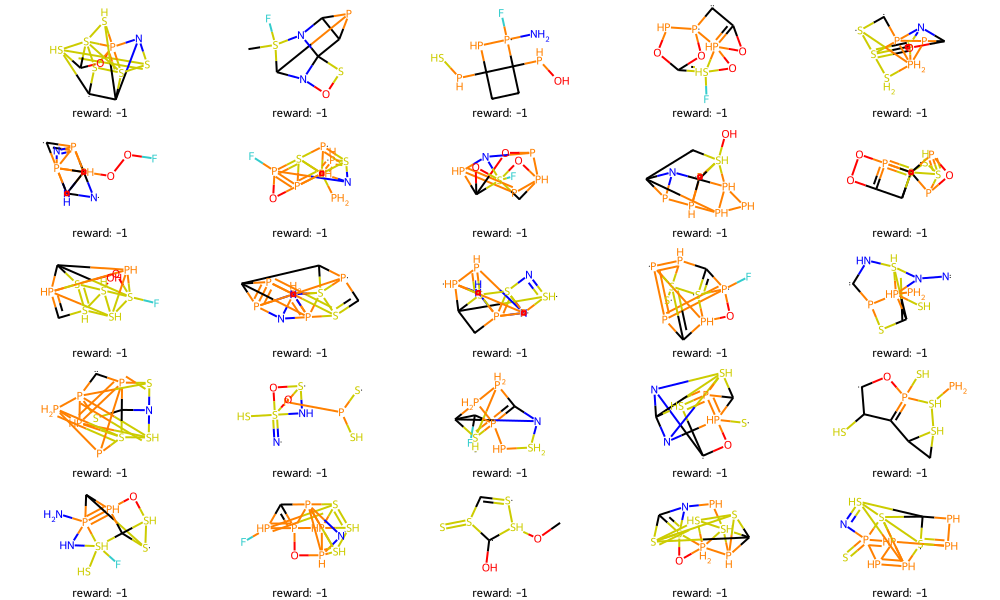

In [11]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
index = 0
rewards = []
for i in is_valid:
    if i:
        rewards.append(list(log_rewards)[index])
        index += 1 
    else:
        rewards.append(-1)

MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r}' if r==-1 else f'reward: {r.exp().item():.2f}' for r in rewards[:25]])


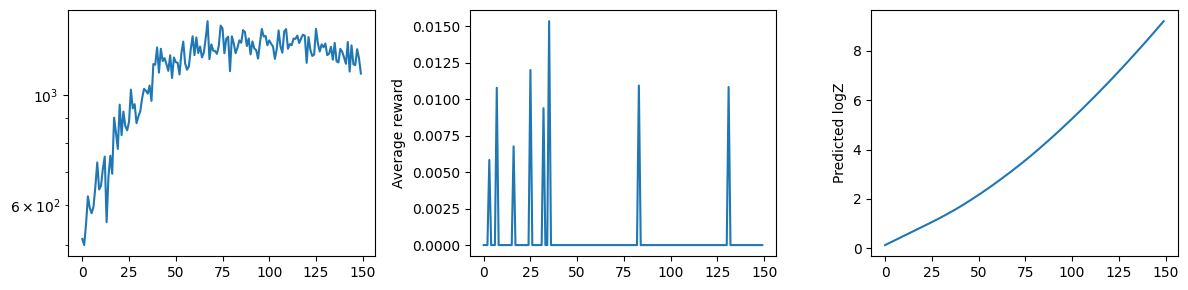

In [12]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator
cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[1].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
pp.tight_layout()

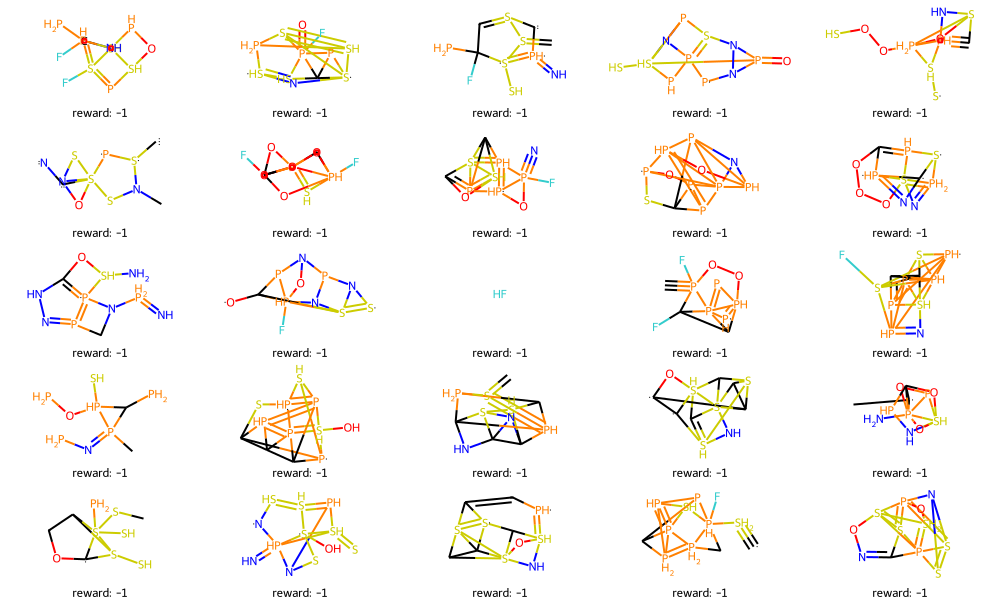

In [14]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
index = 0
rewards = []
for i in is_valid:
    if i:
        rewards.append(list(log_rewards)[index])
        index += 1 
    else:
        rewards.append(-1)

MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r}' if r==-1 else f'reward: {r.exp().item():.2f}' for r in rewards[:25]])